In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook

## Inverting sequence

### Grammar
#### output the first two numbers
ex [43, 3, 28, 34, 33] -> [43, 3]
#### Inverting sequence
ex) '1', '2', '5', '2', '2', '6', '5', '1' -> '1', '5', '6', '2', '2', '5', '2', '1'

In [2]:
from my_utils import Dictionary

n_unique = 10

src_dict = Dictionary(['<EOS>'])
tgt_dict = Dictionary(['<BOS>', '<EOS>'])
for n in range(n_unique):
    src_dict.add_word(str(n))
    tgt_dict.add_word(str(n))

In [3]:
from my_utils.toy_data import first_two, invert_seq
train = invert_seq(5000, n_unique=n_unique)
test = invert_seq(100, n_unique=n_unique)

In [4]:
import torch
from my_utils import DataLoader
from torch_models.utils import seq2seq

def numericalize(dataset, src_dict, tgt_dict):
    numericalized = [([src_dict(s) for s in src], [tgt_dict(t) for t in tgt]) for src, tgt in dataset]
    return numericalized

# device = 'cuda:0'
device = 'cpu'
trans_func = seq2seq(device)

train_loader = DataLoader(numericalize(train, src_dict, tgt_dict), batch_size=64, trans_func=trans_func)
test_loader = DataLoader(numericalize(test, src_dict, tgt_dict), batch_size=16, trans_func=trans_func)

In [5]:
from torch_models import AttnSeq2Seq, Seq2Seq
dim = 100
model = AttnSeq2Seq(dim, dim, len(src_dict), len(tgt_dict),
                    tgt_BOS=tgt_dict('<BOS>'), tgt_EOS=tgt_dict('<EOS>'), src_EOS=src_dict('<EOS>'),
                    num_layers=1, bidirectional=True, device=device)
print(model)

AttnSeq2Seq(
  (encoder): LSTMEncoder(
    (embedding): Embedding(12, 100, padding_idx=11)
    (lstm): LSTM(100, 100, bidirectional=True)
  )
  (decoder): LSTMEncoder(
    (embedding): Embedding(13, 100, padding_idx=12)
    (lstm): LSTM(100, 200)
  )
  (out_mlp): MLP(
    (fc_out): Linear(in_features=400, out_features=12, bias=True)
    (dropout): Dropout(p=0)
    (criterion): CrossEntropyLoss()
    (activation): Tanh()
  )
)


In [9]:
%%time
from my_utils import Trainer, EvaluatorSeq
from torch.optim import Adam

optimizer = Adam(model.parameters())

evaluator = EvaluatorSeq(model, test_loader, measure='BLEU')

trainer = Trainer(model, train_loader)
trainer.train(optimizer, max_epoch=5,
              evaluator=evaluator, score_monitor=None, show_log=True, hook_func=None)

epoch 0  	loss: 0.2616481022744239	BLEU: 0.7496	
epoch 1  	loss: 0.14133286881673185	BLEU: 0.7689	
epoch 2  	loss: 0.0812742434253421	BLEU: 0.7878	
epoch 3  	loss: 0.05193474148459072	BLEU: 0.8087	
epoch 4  	loss: 0.036039203004557874	BLEU: 0.8061	
CPU times: user 1min 27s, sys: 2.39 s, total: 1min 30s
Wall time: 31.4 s


### dim = 100, bidirectional (5 epochs)
#### cuda:0  
CPU times: user 23.6 s, sys: 2.23 s, total: 25.8 s  
Wall time: 25.9 s
#### cpu  
CPU times: user 3min 31s, sys: 5min 22s, total: 8min 53s  
Wall time: 44.5 s

### dim = 500, bidirectional (1 epoch)
#### cuda:0  
CPU times: user 5.06 s, sys: 532 ms, total: 5.59 s  
Wall time: 5.62 s
#### cpu
CPU times: user 4min 43s, sys: 3min 33s, total: 8min 17s  
Wall time: 42 s  

In [8]:
iter(train_loader)
inputs, target = next(train_loader)
l = 10
generated, attn = model.predict(inputs, attention=True)
print('======= input ======')
for seq in inputs[:l]:
    print([src_dict[s.item()] for s in seq])
print('======= output ======')
for seq in generated[:l]:
    print([tgt_dict[s] for s in seq])

======= input ======
['6', '3', '2', '0', '5']
['0', '7', '5', '6']
['6', '1', '5']
['6', '0', '1']
['3', '7', '2', '5']
['2', '7', '9', '6']
['1', '9', '9', '9']
['3', '4', '9']
['3', '4', '3']
['1', '7', '1', '3']
======= output ======
['5', '0', '2', '6', '3']
['6', '5', '7', '0']
['5', '1', '6']
['1', '0', '6']
['5', '2', '7', '3']
['6', '9', '7', '2']
['9', '9', '9', '1']
['9', '4', '3']
['3', '4', '3']
['3', '1', '7', '1']


<IPython.core.display.Javascript object>


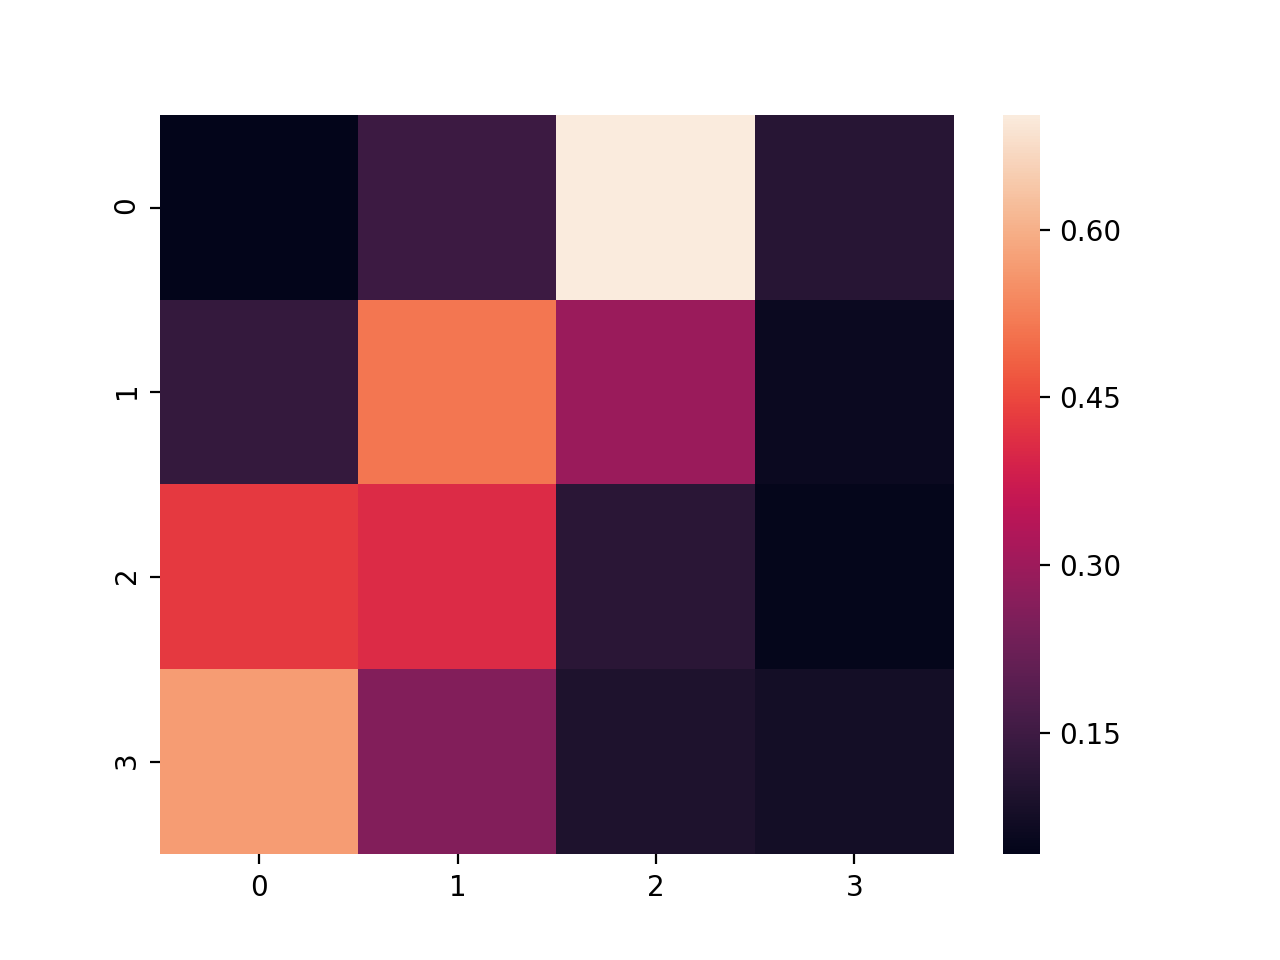

In [10]:
import torch
import seaborn as sns
sns.heatmap(torch.stack(attn[3]).data.cpu().numpy())